In [1]:
#IN google colab install abtem and pycu for gpu acceleration:
#!pip install abtem
#!pip install pycu

%matplotlib inline

from abtem import __version__
print('current version:', __version__)

import matplotlib.pyplot as plt
from ase.io import read
from ase.build import mx2

from abtem import *
from abtem.structures import orthogonalize_cell

from ase.spacegroup import crystal

from ase.visualize import view

from abtem.transfer import scherzer_defocus
import numpy as np

import matplotlib.pyplot as plt

from abtem.utils import fft_shift
from abtem.aperture import DeviatedAperture
import scipy.constants as c

from collections import defaultdict

current version: 1.0.0beta26


In [2]:
def imshow(X, *args, **kwargs): # it seems so that reciprocal arrays (phi or alpha or result of evaluating ctf or aperture) are transformed so that it is neccessary to firstly use fftshift and then mirror the values along axis=0. In arrays which are in direct space (probe image) via probe.build().intensity().array[0] it suffices only to morror the image along axis=0. 
    return plt.imshow(X=np.flip(X,axis=0),*args, **kwargs)
    #return plt.imshow(X=np.swapaxes(X,0,1),*args, **kwargs)
    #return plt.imshow(X=np.swapaxes(np.flip(X,axis=0),0,1),*args, **kwargs)

# SrTiO$_3$

We build an atomic structure of MoS2 with ASE. Since abTEM requires an orthogonal we make the cell orthogonal. We also need to repeat the structure, so the probe fits inside the cell.

<AxesSubplot:title={'center':'Side view'}, xlabel='x [Å]', ylabel='z [Å]'>

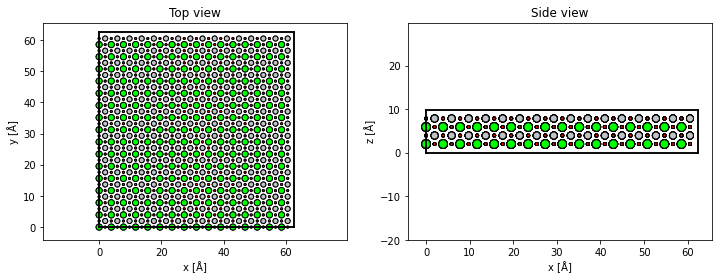

In [3]:
atom_pos = [(0.0, 0.0, 0.0), (0.5, 0.5, 0.5), (0.5, 0.5, 0.0)]
srtio3 = crystal(['Sr','Ti','O'], atom_pos, spacegroup=221, cellpar=3.905, size=(1, 1, 2))
atoms = srtio3

repetitions = (16, 16, 1)

atoms = orthogonalize_cell(atoms)

atoms *= repetitions

atoms.center(vacuum=2, axis=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

show_atoms(atoms, ax=ax1, title='Top view')
show_atoms(atoms, ax=ax2, plane='xz', title='Side view')

In [4]:
#view(atoms)

In [5]:
print(f"Simulation cell: {atoms.cell}")

Simulation cell: Cell([62.48, 62.48, 9.8575])


We create and calculate the electrostatic potential.

In [6]:
gpts=512
potential = Potential(atoms, 
                      gpts=gpts,
                      projection='finite', 
                      slice_thickness=1, 
                      parametrization='kirkland')

potential = potential.build()

10

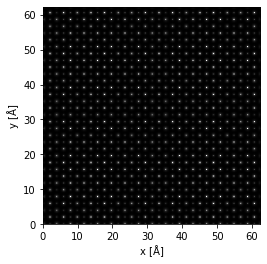

In [7]:
potential.project().show()
len(potential)

In [8]:
print(f"Real space sampling: {potential.sampling}")

Real space sampling: (0.12203125, 0.12203125)


In [9]:
def custom_cartesian2polar(cartesian):
    cartesian = defaultdict(lambda: 0, cartesian)
    max_order = 5
    polar = dict()
    for n in range(1,max_order+1):
        for s in range(0,n+2):
            m = 2*s-n-1
            if m < 0:
                continue

            modulus_name="C"+str(n)+str(m)
            Ca = modulus_name + "a"
            Cb = modulus_name + "b"
            if m != 0:
                argument_name="phi"+str(n)+str(m)
                polar[modulus_name] = np.sqrt(cartesian[Ca]**2 + cartesian[Cb]**2)
                polar[argument_name] = np.arctan2(cartesian[Cb],cartesian[Ca])/m
            else:
                polar[modulus_name] = cartesian[modulus_name]
    return(polar)

In [10]:
#Functions for calculation of abberation coefficients for deviated probe and transformed probe using (C1,A1,...) noteation

In [11]:
from abtem.transfer import cartesian2polar
def m2A(m):
    return(m/1e-10)

def Haider2Krivanek(C1,A1,C3,B2,A2=0+0*1j):
    cartesian = dict()
    
        
    #C1 - C10
    #A1 - C12
    #B2 - 1/3*np.conjugated(C21) !!
    #A2 - # it is zero
    #C3 - C30
    
    cartesian['C10']  = m2A(C1.real)
    cartesian['C12a'] = m2A(A1.real)
    cartesian['C12b'] = m2A(A1.imag)
    cartesian['C21a'] = m2A(3*B2.conjugate().real) # there should be conjugation
    cartesian['C21b'] = m2A(3*B2.conjugate().imag) # there should be conjugation
    cartesian['C30']  = m2A(C3)
    
    cartesian['C23a']  = m2A(A2.real)
    cartesian['C23b']  = m2A(A2.imag)
    return(cartesian)

def get_coeffs(C1,A1,C3,B2=0*1j,A2=0+0*1j): #parameters in argumentC1,A1,.. are original values of aberations in [m]
    A0=0+0*1j
    cartesian = Haider2Krivanek(C1,A1,C3,B2,A2)
    return(m2A(A0).real,m2A(A0).imag,custom_cartesian2polar(cartesian)) #returning in angstrems

def get_transformed_coeffs(C1,A1,C3,delta): #parameters in argument C1, A1,.. are original values of aberations in [m]
    A0_new = C1*delta+A1*delta.conjugate()+C3*delta**2*delta.conjugate()
    C1_new = C1+2*C3*delta*delta.conjugate() #C1_new,A1_new,.. are values of aberations after transformation of variables into the ones with shifted aperture
    A1_new = A1+C3*delta**2
    B2_new = C3*delta.conjugate()# according to theory there should be C3*delta.conjugate() 
    #A2_new =  # it is zero
    C3_new = C3 

    cartesian = Haider2Krivanek(C1_new,A1_new,C3_new,B2_new)

    return(m2A(A0_new).real,m2A(A0_new).imag,custom_cartesian2polar(cartesian)) #returning in angstrems

_, _, aberations_dict = get_transformed_coeffs(C1=0,A1=0,C3=1.9e-3,delta=0+0*1j)



energy=200e3
phi_star=energy*(1-c.elementary_charge*energy/2/c.m_e/c.c**2)

#temporal coherrence
Cc=1.61e-3/1e-10 # In Angstrem
focal_spread=Cc*(0.6/200e3)

#spatial coherrence
reduced_brightness=1e8 
d=1*2*1e-10 # from graph below with C3=0 
I=0.2e-9
alphaa=np.sqrt(4*I/np.pi**2/d**2/reduced_brightness/phi_star)
beta=1/np.e*alphaa*1e3#1/e of angle distribution in [mrad]
angular_spread=beta

defocus_0=scherzer_defocus(Cs=aberations_dict["C30"],energy=energy)        

In [12]:
semiangle_cutoff=9.5

In [13]:
probe = Probe(energy=energy, semiangle_cutoff=semiangle_cutoff, rolloff=0.1, defocus=defocus_0, Cs=aberations_dict["C30"], angular_spread=angular_spread,focal_spread=focal_spread)

To run this simulation using PRISM instead of the standard multislice algorithm, uncomment the cell below. Note that while PRISM may be up to a 1000 times faster than multislice for large structures, the performance is fairly similar for small simulations like this.

In [14]:
#probe = SMatrix(energy=energy, semiangle_cutoff=11.3, expansion_cutoff=20, rolloff=0.1, defocus=defocus_0, Cs=aberations_dict["C30"])
#probe = SMatrix(energy=energy, semiangle_cutoff=9.5, expansion_cutoff=20, rolloff=0.1, defocus=defocus_0, Cs=aberations_dict["C30"],angular_spread=angular_spread,focal_spread=focal_spread)
#_, _, aberations_dict = get_transformed_coeffs(C1=-defocus_0*1e-10,A1=0,C3=1.9e-3,delta=0e-3+0*1j) 
#probe.ctf.set_parameters(aberations_dict)

In [15]:
print("defocus_0: ",defocus_0)
print("angular_spread: ",angular_spread)
print("focal_spread: ",focal_spread)

defocus_0:  845.4355085066284
angular_spread:  4.129003900122874
focal_spread:  48.300000000000004


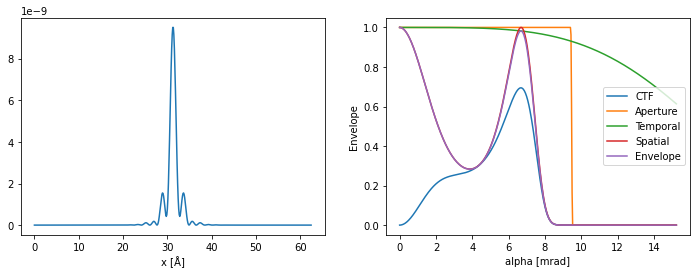

In [16]:
probe.grid.match(potential)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

probe.profile().show(ax=ax1);

probe.ctf.show(ax=ax2);

In [17]:
#Calculate radial intensity of probe and cumulative radial intensity for estimate of probe diameter (at 50% of current)

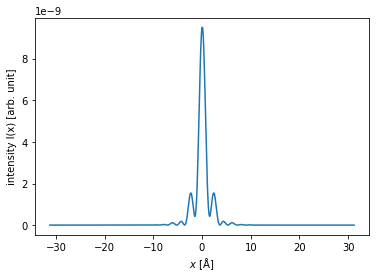

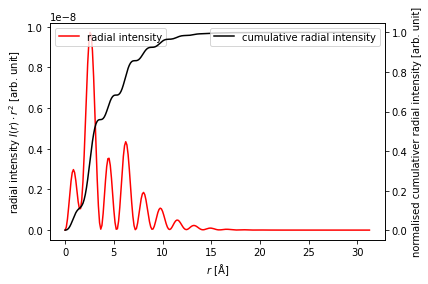

In [18]:
calibration=probe.profile().calibrations[0]
y = probe.profile().array #it is already intensity
x = np.linspace(calibration.offset, calibration.offset + len(y) * calibration.sampling, len(y))
x = x-calibration.sampling*len(y)/2

y_cropped = y[x >= 0]
x_cropped = x[x >= 0]

plt.plot(x,y)
plt.xlabel(r"$x$ [$\mathrm{\AA}$]")
plt.ylabel(r"intensity I(x) [arb. unit]")

radial_intensity = y_cropped * x_cropped**2 

fig, ax1 = plt.subplots() 

plt.plot(x_cropped,radial_intensity,"r",label="radial intensity")

plt.xlabel(r"$r$ [$\mathrm{\AA}$]")
plt.ylabel(r"radial intensity $I(r) \cdot r^2$ [arb. unit]")

ax1.legend(loc=2)

ax2=ax1.twinx()

cumulative_radial_intensity = np.cumsum(radial_intensity)/radial_intensity.sum() #relaying on the fact that sampling in position is equidistant
plt.plot(x_cropped,cumulative_radial_intensity,"k",label="cumulative radial intensity")
plt.ylabel(r"normalised cumulativer radial intensity [arb. unit]")
ax2.legend(loc=1)
plt.show()

In [19]:
#Show probe profile via abtem method

(<AxesSubplot:xlabel='x [Å]'>, <matplotlib.lines.Line2D at 0x7f81980ef550>)

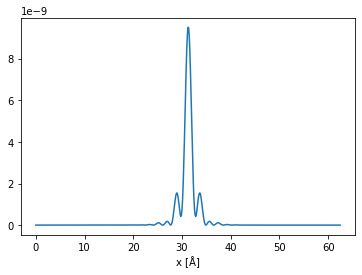

In [20]:
probe.profile().show()

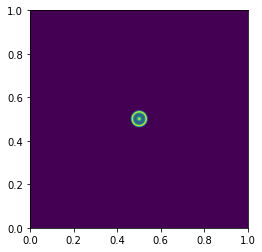

In [21]:
alpha, phi = probe.get_scattering_angles()
imshow(np.absolute(fft_shift(probe.ctf.evaluate_spatial_envelope(alpha,phi),np.array([gpts/2,gpts/2]))),extent=(0,1,0,1))

We create a `FlexibleAnnularDetector` detector which will allow us to choose the integration limits after the multislice simulation.

In [22]:
detector = FlexibleAnnularDetector()

In [279]:
#abberations
#A1s = [0];C1s = np.linspace(-(defocus_0-200)*1e-10,-(defocus_0+200)*1e-10,11);C3 = 1.9e-3 #-Defocus_0=C1a+iC1B=C1
A1s = np.linspace(-60*1e-9,60*1e-9,11);C1s = [-defocus_0*1e-10];C3 = 1.9e-3
delta_divisions = 7
#delta_semiangle = semiangle_cutoff
delta_semiangle =  2 # in mrad
deltas=np.zeros([delta_divisions,delta_divisions],np.complex256)
for i,delta_x in enumerate(np.linspace(-delta_semiangle*1e-3,delta_semiangle*1e-3,delta_divisions)):
    for j,delta_y in enumerate(np.linspace(delta_semiangle*1e-3,-delta_semiangle*1e-3,delta_divisions)):
        deltas[i,j]=delta_x+delta_y*1j
print(deltas)

deltas=np.array([np.linspace(delta_semiangle*1e-3,-delta_semiangle*1e-3,delta_divisions)])

index=0
for C1 in C1s:
    for A1 in A1s:
        for delta_row in deltas:
            for delta in delta_row:
                print(index);index += 1
                probe_transformed = Probe(energy=energy, semiangle_cutoff=semiangle_cutoff, rolloff=0.1, angular_spread=angular_spread,focal_spread=focal_spread)
                probe_transformed.grid.match(potential)

                C01a, C01b, aberations_dict_transformed = get_transformed_coeffs(C1=C1,A1=A1,C3=C3,delta=delta) #arguments in [m] and returns in angstrem
                probe_transformed.ctf.set_parameters(aberations_dict_transformed)
                print(probe_transformed.ctf.parameters)
                
                C01 = np.array([C01b,C01a])
                start = np.array([0,0])+C01 # it is supposed to be in angstrems
                end = np.array((potential.extent[0] / repetitions[0], potential.extent[1] / repetitions[1]))+C01
                gridscan = GridScan(start=start, end=end, sampling=probe_transformed.ctf.nyquist_sampling * .9)

                measurement_transformed = probe_transformed.scan(gridscan, detector, potential)
                measurement_transformed.integrate(50,80).interpolate(0.05).save_as_image("figs/{index:05d}_C1_{C1:.1f}-A1_{A1:.1f}-C3_{C3:.1f}-deltax_{deltax:.1f}-deltay_{deltay:.1f}.png".format(index=index,C1=C1/1e-10,A1=A1/1e-10,C3=C3/1e-10,deltax=delta.real*1e3,deltay=delta.imag*1e3))

[[-0.002     +0.002j      -0.002     +0.00133333j -0.002     +0.00066667j
  -0.002     +0.j         -0.002     -0.00066667j -0.002     -0.00133333j
  -0.002     -0.002j     ]
 [-0.00133333+0.002j      -0.00133333+0.00133333j -0.00133333+0.00066667j
  -0.00133333+0.j         -0.00133333-0.00066667j -0.00133333-0.00133333j
  -0.00133333-0.002j     ]
 [-0.00066667+0.002j      -0.00066667+0.00133333j -0.00066667+0.00066667j
  -0.00066667+0.j         -0.00066667-0.00066667j -0.00066667-0.00133333j
  -0.00066667-0.002j     ]
 [ 0.        +0.002j       0.        +0.00133333j  0.        +0.00066667j
   0.        +0.j          0.        -0.00066667j  0.        -0.00133333j
   0.        -0.002j     ]
 [ 0.00066667+0.002j       0.00066667+0.00133333j  0.00066667+0.00066667j
   0.00066667+0.j          0.00066667-0.00066667j  0.00066667-0.00133333j
   0.00066667-0.002j     ]
 [ 0.00133333+0.002j       0.00133333+0.00133333j  0.00133333+0.00066667j
   0.00133333+0.j          0.00133333-0.00066667j  

Scan:   0%|          | 0/49 [00:00<?, ?it/s]

1
delta:  0.0013333333333333335
A1:  -6.000000000000001e-08
A0_new:  -1.882210307638468e-10
{'C10': -777.8799529510728, 'C12': 566.2222222222223, 'phi12': 1.5707963267948966, 'C21': 76000.00000000001, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

2
delta:  0.0006666666666666668
A1:  -6.000000000000001e-08
A0_new:  -9.579940427081228e-11
{'C10': -828.5466196177395, 'C12': 591.5555555555555, 'phi12': 1.5707963267948966, 'C21': 38000.00000000001, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

3
delta:  0.0
A1:  -6.000000000000001e-08
A0_new:  0.0
{'C10': -845.4355085066284, 'C12': 600.0000000000001, 'phi12': 1.5707963267948966, 'C21': 0.0, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

4
delta:  -0.0006666666666666665
A1:  -6.000000000000001e-08
A0_new:  9.579940427081225e-11
{'C10': -828.5466196177396, 'C12': 591.5555555555557, 'phi12': 1.5707963267948966, 'C21': 37999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

5
delta:  -0.001333333333333333
A1:  -6.000000000000001e-08
A0_new:  1.8822103076384674e-10
{'C10': -777.8799529510728, 'C12': 566.2222222222223, 'phi12': 1.5707963267948966, 'C21': 75999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

6
delta:  -0.002
A1:  -6.000000000000001e-08
A0_new:  2.7388710170132573e-10
{'C10': -693.4355085066284, 'C12': 524.0, 'phi12': 1.5707963267948966, 'C21': 113999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

7
delta:  0.002
A1:  -4.8000000000000006e-08
A0_new:  -2.498871017013257e-10
{'C10': -693.4355085066284, 'C12': 404.00000000000006, 'phi12': 1.5707963267948966, 'C21': 113999.99999999999, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

8
delta:  0.0013333333333333335
A1:  -4.8000000000000006e-08
A0_new:  -1.722210307638468e-10
{'C10': -777.8799529510728, 'C12': 446.2222222222223, 'phi12': 1.5707963267948966, 'C21': 76000.00000000001, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

9
delta:  0.0006666666666666668
A1:  -4.8000000000000006e-08
A0_new:  -8.779940427081228e-11
{'C10': -828.5466196177395, 'C12': 471.55555555555554, 'phi12': 1.5707963267948966, 'C21': 38000.00000000001, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

10
delta:  0.0
A1:  -4.8000000000000006e-08
A0_new:  0.0
{'C10': -845.4355085066284, 'C12': 480.00000000000006, 'phi12': 1.5707963267948966, 'C21': 0.0, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

11
delta:  -0.0006666666666666665
A1:  -4.8000000000000006e-08
A0_new:  8.779940427081225e-11
{'C10': -828.5466196177396, 'C12': 471.55555555555566, 'phi12': 1.5707963267948966, 'C21': 37999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

12
delta:  -0.001333333333333333
A1:  -4.8000000000000006e-08
A0_new:  1.7222103076384674e-10
{'C10': -777.8799529510728, 'C12': 446.2222222222223, 'phi12': 1.5707963267948966, 'C21': 75999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

13
delta:  -0.002
A1:  -4.8000000000000006e-08
A0_new:  2.498871017013257e-10
{'C10': -693.4355085066284, 'C12': 404.00000000000006, 'phi12': 1.5707963267948966, 'C21': 113999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

14
delta:  0.002
A1:  -3.6000000000000005e-08
A0_new:  -2.2588710170132568e-10
{'C10': -693.4355085066284, 'C12': 284.0, 'phi12': 1.5707963267948966, 'C21': 113999.99999999999, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

15
delta:  0.0013333333333333335
A1:  -3.6000000000000005e-08
A0_new:  -1.562210307638468e-10
{'C10': -777.8799529510728, 'C12': 326.2222222222223, 'phi12': 1.5707963267948966, 'C21': 76000.00000000001, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

16
delta:  0.0006666666666666668
A1:  -3.6000000000000005e-08
A0_new:  -7.979940427081228e-11
{'C10': -828.5466196177395, 'C12': 351.55555555555554, 'phi12': 1.5707963267948966, 'C21': 38000.00000000001, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

17
delta:  0.0
A1:  -3.6000000000000005e-08
A0_new:  0.0
{'C10': -845.4355085066284, 'C12': 360.00000000000006, 'phi12': 1.5707963267948966, 'C21': 0.0, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

18
delta:  -0.0006666666666666665
A1:  -3.6000000000000005e-08
A0_new:  7.979940427081225e-11
{'C10': -828.5466196177396, 'C12': 351.5555555555556, 'phi12': 1.5707963267948966, 'C21': 37999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

19
delta:  -0.001333333333333333
A1:  -3.6000000000000005e-08
A0_new:  1.5622103076384672e-10
{'C10': -777.8799529510728, 'C12': 326.2222222222223, 'phi12': 1.5707963267948966, 'C21': 75999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

20
delta:  -0.002
A1:  -3.6000000000000005e-08
A0_new:  2.2588710170132568e-10
{'C10': -693.4355085066284, 'C12': 284.0, 'phi12': 1.5707963267948966, 'C21': 113999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

21
delta:  0.002
A1:  -2.4000000000000003e-08
A0_new:  -2.018871017013257e-10
{'C10': -693.4355085066284, 'C12': 164.0, 'phi12': 1.5707963267948966, 'C21': 113999.99999999999, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

22
delta:  0.0013333333333333335
A1:  -2.4000000000000003e-08
A0_new:  -1.4022103076384677e-10
{'C10': -777.8799529510728, 'C12': 206.22222222222226, 'phi12': 1.5707963267948966, 'C21': 76000.00000000001, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

23
delta:  0.0006666666666666668
A1:  -2.4000000000000003e-08
A0_new:  -7.179940427081227e-11
{'C10': -828.5466196177395, 'C12': 231.55555555555557, 'phi12': 1.5707963267948966, 'C21': 38000.00000000001, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

24
delta:  0.0
A1:  -2.4000000000000003e-08
A0_new:  0.0
{'C10': -845.4355085066284, 'C12': 240.00000000000003, 'phi12': 1.5707963267948966, 'C21': 0.0, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

25
delta:  -0.0006666666666666665
A1:  -2.4000000000000003e-08
A0_new:  7.179940427081226e-11
{'C10': -828.5466196177396, 'C12': 231.55555555555557, 'phi12': 1.5707963267948966, 'C21': 37999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

26
delta:  -0.001333333333333333
A1:  -2.4000000000000003e-08
A0_new:  1.4022103076384672e-10
{'C10': -777.8799529510728, 'C12': 206.22222222222226, 'phi12': 1.5707963267948966, 'C21': 75999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

27
delta:  -0.002
A1:  -2.4000000000000003e-08
A0_new:  2.018871017013257e-10
{'C10': -693.4355085066284, 'C12': 164.0, 'phi12': 1.5707963267948966, 'C21': 113999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

28
delta:  0.002
A1:  -1.2000000000000002e-08
A0_new:  -1.7788710170132567e-10
{'C10': -693.4355085066284, 'C12': 44.000000000000014, 'phi12': 1.5707963267948966, 'C21': 113999.99999999999, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

29
delta:  0.0013333333333333335
A1:  -1.2000000000000002e-08
A0_new:  -1.2422103076384678e-10
{'C10': -777.8799529510728, 'C12': 86.22222222222223, 'phi12': 1.5707963267948966, 'C21': 76000.00000000001, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

30
delta:  0.0006666666666666668
A1:  -1.2000000000000002e-08
A0_new:  -6.379940427081227e-11
{'C10': -828.5466196177395, 'C12': 111.55555555555557, 'phi12': 1.5707963267948966, 'C21': 38000.00000000001, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

31
delta:  0.0
A1:  -1.2000000000000002e-08
A0_new:  0.0
{'C10': -845.4355085066284, 'C12': 120.00000000000001, 'phi12': 1.5707963267948966, 'C21': 0.0, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

32
delta:  -0.0006666666666666665
A1:  -1.2000000000000002e-08
A0_new:  6.379940427081226e-11
{'C10': -828.5466196177396, 'C12': 111.55555555555557, 'phi12': 1.5707963267948966, 'C21': 37999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

33
delta:  -0.001333333333333333
A1:  -1.2000000000000002e-08
A0_new:  1.2422103076384673e-10
{'C10': -777.8799529510728, 'C12': 86.22222222222224, 'phi12': 1.5707963267948966, 'C21': 75999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

34
delta:  -0.002
A1:  -1.2000000000000002e-08
A0_new:  1.7788710170132567e-10
{'C10': -693.4355085066284, 'C12': 44.000000000000014, 'phi12': 1.5707963267948966, 'C21': 113999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

35
delta:  0.002
A1:  0.0
A0_new:  -1.5388710170132568e-10
{'C10': -693.4355085066284, 'C12': 76.0, 'phi12': 0.0, 'C21': 113999.99999999999, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

36
delta:  0.0013333333333333335
A1:  0.0
A0_new:  -1.0822103076384677e-10
{'C10': -777.8799529510728, 'C12': 33.777777777777786, 'phi12': 0.0, 'C21': 76000.00000000001, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

37
delta:  0.0006666666666666668
A1:  0.0
A0_new:  -5.579940427081227e-11
{'C10': -828.5466196177395, 'C12': 8.444444444444446, 'phi12': 0.0, 'C21': 38000.00000000001, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

38
delta:  0.0
A1:  0.0
A0_new:  0.0
{'C10': -845.4355085066284, 'C12': 0.0, 'phi12': 0.0, 'C21': 0.0, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

39
delta:  -0.0006666666666666665
A1:  0.0
A0_new:  5.579940427081225e-11
{'C10': -828.5466196177396, 'C12': 8.444444444444441, 'phi12': 0.0, 'C21': 37999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

40
delta:  -0.001333333333333333
A1:  0.0
A0_new:  1.0822103076384673e-10
{'C10': -777.8799529510728, 'C12': 33.777777777777764, 'phi12': 0.0, 'C21': 75999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

41
delta:  -0.002
A1:  0.0
A0_new:  1.5388710170132568e-10
{'C10': -693.4355085066284, 'C12': 76.0, 'phi12': 0.0, 'C21': 113999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

42
delta:  0.002
A1:  1.2000000000000002e-08
A0_new:  -1.2988710170132568e-10
{'C10': -693.4355085066284, 'C12': 196.00000000000003, 'phi12': 0.0, 'C21': 113999.99999999999, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

43
delta:  0.0013333333333333335
A1:  1.2000000000000002e-08
A0_new:  -9.222103076384676e-11
{'C10': -777.8799529510728, 'C12': 153.77777777777777, 'phi12': 0.0, 'C21': 76000.00000000001, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

44
delta:  0.0006666666666666668
A1:  1.2000000000000002e-08
A0_new:  -4.779940427081227e-11
{'C10': -828.5466196177395, 'C12': 128.44444444444446, 'phi12': 0.0, 'C21': 38000.00000000001, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

45
delta:  0.0
A1:  1.2000000000000002e-08
A0_new:  0.0
{'C10': -845.4355085066284, 'C12': 120.00000000000001, 'phi12': 0.0, 'C21': 0.0, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

46
delta:  -0.0006666666666666665
A1:  1.2000000000000002e-08
A0_new:  4.7799404270812254e-11
{'C10': -828.5466196177396, 'C12': 128.44444444444446, 'phi12': 0.0, 'C21': 37999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

47
delta:  -0.001333333333333333
A1:  1.2000000000000002e-08
A0_new:  9.222103076384673e-11
{'C10': -777.8799529510728, 'C12': 153.77777777777777, 'phi12': 0.0, 'C21': 75999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

48
delta:  -0.002
A1:  1.2000000000000002e-08
A0_new:  1.2988710170132568e-10
{'C10': -693.4355085066284, 'C12': 196.00000000000003, 'phi12': 0.0, 'C21': 113999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

49
delta:  0.002
A1:  2.4000000000000003e-08
A0_new:  -1.0588710170132567e-10
{'C10': -693.4355085066284, 'C12': 316.00000000000006, 'phi12': 0.0, 'C21': 113999.99999999999, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

50
delta:  0.0013333333333333335
A1:  2.4000000000000003e-08
A0_new:  -7.622103076384676e-11
{'C10': -777.8799529510728, 'C12': 273.77777777777777, 'phi12': 0.0, 'C21': 76000.00000000001, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

51
delta:  0.0006666666666666668
A1:  2.4000000000000003e-08
A0_new:  -3.979940427081227e-11
{'C10': -828.5466196177395, 'C12': 248.44444444444446, 'phi12': 0.0, 'C21': 38000.00000000001, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

52
delta:  0.0
A1:  2.4000000000000003e-08
A0_new:  0.0
{'C10': -845.4355085066284, 'C12': 240.00000000000003, 'phi12': 0.0, 'C21': 0.0, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

53
delta:  -0.0006666666666666665
A1:  2.4000000000000003e-08
A0_new:  3.9799404270812256e-11
{'C10': -828.5466196177396, 'C12': 248.44444444444446, 'phi12': 0.0, 'C21': 37999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

54
delta:  -0.001333333333333333
A1:  2.4000000000000003e-08
A0_new:  7.622103076384674e-11
{'C10': -777.8799529510728, 'C12': 273.77777777777777, 'phi12': 0.0, 'C21': 75999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

55
delta:  -0.002
A1:  2.4000000000000003e-08
A0_new:  1.0588710170132567e-10
{'C10': -693.4355085066284, 'C12': 316.00000000000006, 'phi12': 0.0, 'C21': 113999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

56
delta:  0.002
A1:  3.6000000000000005e-08
A0_new:  -8.188710170132568e-11
{'C10': -693.4355085066284, 'C12': 436.00000000000006, 'phi12': 0.0, 'C21': 113999.99999999999, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

57
delta:  0.0013333333333333335
A1:  3.6000000000000005e-08
A0_new:  -6.022103076384675e-11
{'C10': -777.8799529510728, 'C12': 393.7777777777778, 'phi12': 0.0, 'C21': 76000.00000000001, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

58
delta:  0.0006666666666666668
A1:  3.6000000000000005e-08
A0_new:  -3.1799404270812264e-11
{'C10': -828.5466196177395, 'C12': 368.4444444444445, 'phi12': 0.0, 'C21': 38000.00000000001, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

59
delta:  0.0
A1:  3.6000000000000005e-08
A0_new:  0.0
{'C10': -845.4355085066284, 'C12': 360.00000000000006, 'phi12': 0.0, 'C21': 0.0, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

60
delta:  -0.0006666666666666665
A1:  3.6000000000000005e-08
A0_new:  3.179940427081226e-11
{'C10': -828.5466196177396, 'C12': 368.44444444444446, 'phi12': 0.0, 'C21': 37999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

61
delta:  -0.001333333333333333
A1:  3.6000000000000005e-08
A0_new:  6.022103076384674e-11
{'C10': -777.8799529510728, 'C12': 393.7777777777778, 'phi12': 0.0, 'C21': 75999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

62
delta:  -0.002
A1:  3.6000000000000005e-08
A0_new:  8.188710170132568e-11
{'C10': -693.4355085066284, 'C12': 436.00000000000006, 'phi12': 0.0, 'C21': 113999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

63
delta:  0.002
A1:  4.8000000000000006e-08
A0_new:  -5.788710170132567e-11
{'C10': -693.4355085066284, 'C12': 556.0000000000001, 'phi12': 0.0, 'C21': 113999.99999999999, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

64
delta:  0.0013333333333333335
A1:  4.8000000000000006e-08
A0_new:  -4.422103076384675e-11
{'C10': -777.8799529510728, 'C12': 513.7777777777778, 'phi12': 0.0, 'C21': 76000.00000000001, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

65
delta:  0.0006666666666666668
A1:  4.8000000000000006e-08
A0_new:  -2.3799404270812266e-11
{'C10': -828.5466196177395, 'C12': 488.4444444444445, 'phi12': 0.0, 'C21': 38000.00000000001, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

66
delta:  0.0
A1:  4.8000000000000006e-08
A0_new:  0.0
{'C10': -845.4355085066284, 'C12': 480.00000000000006, 'phi12': 0.0, 'C21': 0.0, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

67
delta:  -0.0006666666666666665
A1:  4.8000000000000006e-08
A0_new:  2.3799404270812253e-11
{'C10': -828.5466196177396, 'C12': 488.44444444444446, 'phi12': 0.0, 'C21': 37999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

68
delta:  -0.001333333333333333
A1:  4.8000000000000006e-08
A0_new:  4.422103076384673e-11
{'C10': -777.8799529510728, 'C12': 513.7777777777778, 'phi12': 0.0, 'C21': 75999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

69
delta:  -0.002
A1:  4.8000000000000006e-08
A0_new:  5.788710170132567e-11
{'C10': -693.4355085066284, 'C12': 556.0000000000001, 'phi12': 0.0, 'C21': 113999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

70
delta:  0.002
A1:  6.000000000000001e-08
A0_new:  -3.388710170132566e-11
{'C10': -693.4355085066284, 'C12': 676.0000000000001, 'phi12': 0.0, 'C21': 113999.99999999999, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

71
delta:  0.0013333333333333335
A1:  6.000000000000001e-08
A0_new:  -2.8221030763846744e-11
{'C10': -777.8799529510728, 'C12': 633.7777777777778, 'phi12': 0.0, 'C21': 76000.00000000001, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

72
delta:  0.0006666666666666668
A1:  6.000000000000001e-08
A0_new:  -1.579940427081226e-11
{'C10': -828.5466196177395, 'C12': 608.4444444444446, 'phi12': 0.0, 'C21': 38000.00000000001, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

73
delta:  0.0
A1:  6.000000000000001e-08
A0_new:  0.0
{'C10': -845.4355085066284, 'C12': 600.0000000000001, 'phi12': 0.0, 'C21': 0.0, 'phi21': 0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

74
delta:  -0.0006666666666666665
A1:  6.000000000000001e-08
A0_new:  1.5799404270812255e-11
{'C10': -828.5466196177396, 'C12': 608.4444444444446, 'phi12': 0.0, 'C21': 37999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

75
delta:  -0.001333333333333333
A1:  6.000000000000001e-08
A0_new:  2.8221030763846735e-11
{'C10': -777.8799529510728, 'C12': 633.7777777777778, 'phi12': 0.0, 'C21': 75999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

76
delta:  -0.002
A1:  6.000000000000001e-08
A0_new:  3.388710170132566e-11
{'C10': -693.4355085066284, 'C12': 676.0000000000001, 'phi12': 0.0, 'C21': 113999.99999999999, 'phi21': 3.141592653589793, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

In [23]:
#Show transformed probe

{'C10': 152.0, 'C12': 76.0, 'phi12': 0.0, 'C21': 113999.99999999999, 'phi21': -0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}
[0.    0.152]


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7f81983b5cd0>)

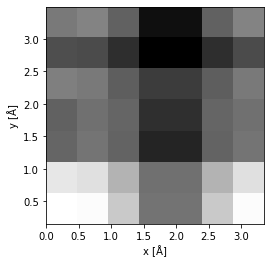

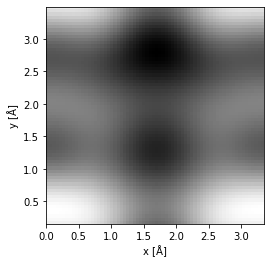

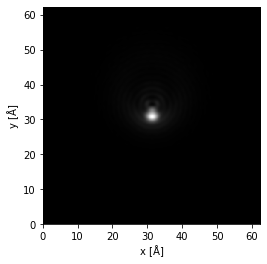

In [23]:
C3 = 1.9e-3#1.9e-3# in meters
defocus_0 = 0#defocus_0#1000#-1000#845#1000# in angstrem
A1 = 0#600e-10#500e-10#500e-10#100e-10#1000e-10#*(1+1j) in meters
probe_transformed = Probe(energy=energy, semiangle_cutoff=semiangle_cutoff, rolloff=0.1)#, angular_spread=angular_spread,focal_spread=focal_spread)
probe_transformed.grid.match(potential)

delta=2e-3+0e-3j
C01a, C01b, aberations_dict_transformed = get_transformed_coeffs(C1=-defocus_0*1e-10,A1=A1,C3=C3,delta=delta) #arguments in [m] and returns in angstrem
probe_transformed.ctf.set_parameters(aberations_dict_transformed)
print(probe_transformed.ctf.parameters)

C01 = np.array([C01b,C01a]) # I suppose that the coefficients should be interchanged so that x is C01b and y is C01a 
print(C01)
start = np.array([0,0]) + C01 # it is supposed to be in angstrems
end = np.array((potential.extent[0] / repetitions[0], potential.extent[1] / repetitions[1])) + C01
gridscan = GridScan(start=start, end=end, sampling=probe_transformed.ctf.nyquist_sampling * .9)

#%matplotlib qt
measurement = probe_transformed.scan(gridscan, detector, potential)
measurement.integrate(50,80).show()
measurement.integrate(50,80).interpolate(0.05).show()
probe_transformed.show()
#print(np.shape(measurement.array))

In [24]:
#Show deviated probe

{'C10': 0.0, 'C12': 0.0, 'phi12': 0.0, 'C21': 0.0, 'phi21': -0.0, 'C23': 0.0, 'phi23': 0.0, 'C30': 19000000.0, 'C32': 0.0, 'phi32': 0.0, 'C34': 0.0, 'phi34': 0.0, 'C41': 0.0, 'phi41': 0.0, 'C43': 0.0, 'phi43': 0.0, 'C45': 0.0, 'phi45': 0.0, 'C50': 0, 'C52': 0.0, 'phi52': 0.0, 'C54': 0.0, 'phi54': 0.0, 'C56': 0.0, 'phi56': 0.0}


Scan:   0%|          | 0/49 [00:00<?, ?it/s]

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7f8190466ee0>)

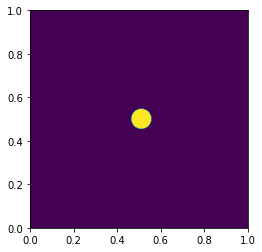

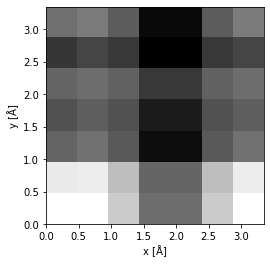

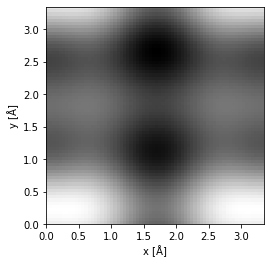

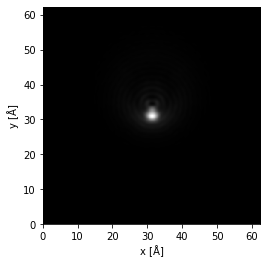

In [25]:
aperture = DeviatedAperture(aperture_angle=semiangle_cutoff,x_0=delta.real*1e3,y_0=delta.imag*1e3)

probe_deviated = Probe(aperture=aperture, energy=energy, semiangle_cutoff=semiangle_cutoff+np.absolute(delta), rolloff=0.1)#, angular_spread=angular_spread,focal_spread=focal_spread)
probe_deviated.grid.match(potential)
imshow(np.absolute(fft_shift(probe_deviated.ctf.evaluate_aperture(alpha,phi),np.array([gpts/2,gpts/2]))),extent=(0,1,0,1))

_, _, aberations_dict_deviated = get_coeffs(C1=-defocus_0*1e-10,A1=A1,C3=C3,B2=(0+0j)*1e-6,A2=(0+0j)*30e-6) #arguments in [m] and returns in angstrem
probe_deviated.ctf.set_parameters(aberations_dict_deviated)
#probe_deviated.ctf.set_parameters({'phi12': -3.1415/4})
print(probe_deviated.ctf.parameters)

start = np.array([0,0]) # it is supposed to be in angstrems
end = np.array((potential.extent[0] / repetitions[0], potential.extent[1] / repetitions[1]))
gridscan = GridScan(start=start, end=end, sampling=probe_deviated.ctf.nyquist_sampling * .9)

measurement_deviated = probe_deviated.scan(gridscan, detector, potential)
measurement_deviated.integrate(50,80).show()
measurement_deviated.integrate(50,80).interpolate(0.05).show()
probe_deviated.show()

#print(np.shape(measurement_deviated.array))

In [26]:
#Showing probes via abtem methods

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7f8198112af0>)

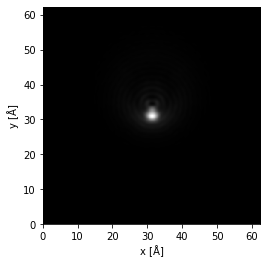

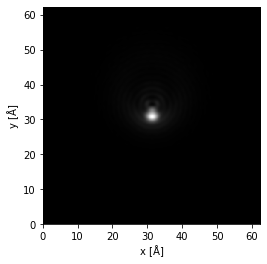

In [27]:
#%matplotlib qt
probe_deviated.show(log_scale=False)
probe_transformed.show(log_scale=False)

In [28]:
#Shifting transformed probe to see that it is simmilar to deviated one

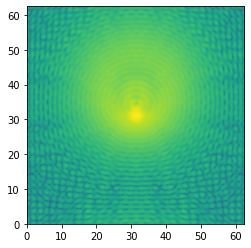

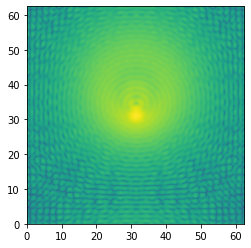

In [29]:
#%matplotlib qt
image_deviated=np.log(np.absolute(fft_shift(probe_deviated.build().intensity().array,np.array([0,0]))))[0]
image_transformed=np.log(np.absolute(fft_shift(probe_transformed.build().intensity().array,C01/probe_transformed.grid.sampling)))[0]
plt.figure()

extent=np.array(probe_deviated.grid.gpts)*probe_deviated.grid.sampling
imshow(np.swapaxes(image_deviated,0,1),extent=(0,extent[0],0,extent[1]))
plt.figure()
imshow(np.swapaxes(image_transformed,0,1),extent=(0,extent[0],0,extent[1]))
plt.show()

In [30]:
#Showing aperture

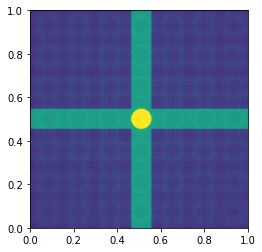

In [31]:
%matplotlib inline
values=probe_deviated.ctf.evaluate_aperture(alpha,phi)
image=np.log(np.absolute(fft_shift(values,np.array([gpts/2,gpts/2]))))
imshow(image,extent=(0,1,0,1))

In [32]:
#Show azimuthal angle phi

Text(0, 0.5, 'alpha_y')

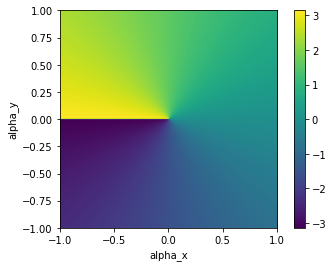

In [33]:
imshow(np.real(fft_shift(phi,np.array([gpts/2,-gpts/2]))),extent=(-1,1,-1,1)); plt.colorbar()
plt.xlabel("alpha_x")
plt.ylabel("alpha_y")

#imshow(np.absolute(fft_shift(probe_deviated.ctf.evaluate_aperture(alpha,phi),np.array([gpts/2,-gpts/2]))),extent=(0,1,0,1))
#imshow(np.absolute(probe_deviated.ctf.evaluate_aperture(alpha,phi)),extent=(0,1,0,1))

In [34]:
#Showing probe without np.swapaxes(...,0,1) and only with mirroring along axis=0

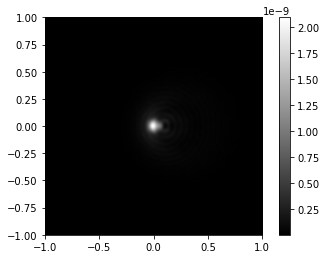

In [35]:
imshow(np.real(probe_deviated.build().intensity().array[0]),cmap="gray",extent=(-1,1,-1,1)); plt.colorbar()

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7f819829e250>)

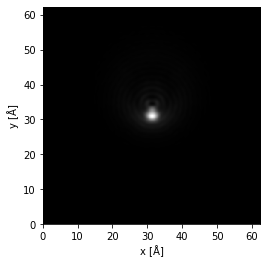

In [36]:
probe_deviated.show()

In [37]:
#Croscorrelation of obtained probes via deviation and transformation and their relative simillarity

integrated squared probe (deviated) p_d = 1.4701779e-15
maximal value in convolution p_c =  1.4828866e-15
fraction p_c/p_d =  1.0086443


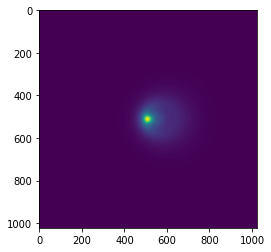

In [38]:
from scipy  import signal
p_deviated = np.abs(probe_deviated.build().intensity().array[0])
p_transformed = np.abs(probe_transformed.build().intensity().array[0])

p_deviated_sq = signal.fftconvolve(p_deviated,p_deviated[::-1]).max()

print("integrated squared probe (deviated) p_d =",p_deviated_sq)

conv = signal.fftconvolve(p_deviated,p_transformed[::-1])
imshow(conv)

print("maximal value in convolution p_c = ",conv.max())

print("fraction p_c/p_d = ",conv.max()/p_deviated_sq)